In [1]:
# File: ./kan_iris.py
# Purpose: Train a KAN-inspired classifier on the Iris dataset using B-spline
#          activations implemented via Cox–de Boor recursion.
# Notes:
#   - Uses class indices (not one-hot) with CrossEntropyLoss (PyTorch best practice).
#   - B-spline weights are per input feature for better capacity.
#   - Includes loss curve and an example of learned (weighted) activation visualization.

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# Utilities: Reproducibility
# -----------------------------
def set_seed(seed: int = 42) -> None:
    """Set seeds for Python, NumPy, and PyTorch to make runs repeatable."""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
# -----------------------------------------
# Segment A: Data loading and preprocessing
# -----------------------------------------
def load_iris_tensors(test_size=0.2, seed=42, device="cpu"):
    """
    Load Iris, standardize features, split into train/test, and return tensors.

    Returns:
        X_train: (N_train, 4) float32 tensor
        y_train: (N_train,) int64 class indices {0,1,2}
        X_test:  (N_test, 4) float32 tensor
        y_test:  (N_test,) int64 class indices
        scaler:  fitted StandardScaler (for optional inverse-transform/plots)
    """
    iris = load_iris()
    X = iris.data.astype(np.float32)      # (150, 4)
    y = iris.target.astype(np.int64)      # (150,), class indices

    scaler = StandardScaler()
    X = scaler.fit_transform(X).astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )

    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.long, device=device)
    X_test = torch.tensor(X_test,  dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test,  dtype=torch.long, device=device)

    return X_train, y_train, X_test, y_test, scaler

In [4]:
# ---------------------------------------------------------
# Segment B: B-spline basis via Cox–de Boor (KAN activation)
# ---------------------------------------------------------
class BSplineActivation(nn.Module):
    """
    B-spline activation module.

    - For each input feature x[:, i], compute its B-spline basis expansion B (batch, num_basis)
      and apply a learned weight vector W[i] -> output feature z[:, i] = B @ W[i].
    - Per-feature weights allow different nonlinearities per input dimension.

    Args:
        input_dim: number of input features
        num_knots: number of knots in the knot vector
        degree:    spline degree (order = degree + 1)
        knot_min, knot_max: range to place uniform knots (should cover standardized inputs)

    Output shape:
        (batch, input_dim) — same number of features, each nonlinearly transformed
    """

    def __init__(self,
                 input_dim: int,
                 num_knots: int = 11,
                 degree: int = 3,
                 knot_min: float = -2.5,
                 knot_max: float = 3.2):
        super().__init__()
        assert num_knots > degree + \
            1, "num_knots must be > degree + 1 to have positive num_basis."
        self.input_dim = input_dim
        self.degree = degree

        # Uniform knot vector spanning the (standardized) feature range.
        knots = np.linspace(knot_min, knot_max, num_knots).astype(np.float32)
        self.register_buffer("knots", torch.tensor(
            knots, dtype=torch.float32))  # not a parameter

        # Number of basis functions = num_knots - degree - 1
        self.num_basis = num_knots - degree - 1

        # Per-feature weight vectors: shape (input_dim, num_basis)
        # Each row corresponds to one feature's basis combination weights.
        self.weights = nn.Parameter(
            torch.randn(input_dim, self.num_basis) * 0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, input_dim)

        Returns:
            out: (batch, input_dim) transformed via learned B-spline activations.
        """
        assert x.dim() == 2 and x.size(1) == self.input_dim, "Input shape mismatch."
        batch, D = x.shape
        out = torch.empty_like(x)

        # For each feature independently, compute its basis and apply weights.
        for i in range(D):
            # B: (batch, num_basis)
            B = self._b_spline_matrix(x[:, i])
            # Weighted activation: (batch,)
            out[:, i] = B @ self.weights[i]

        return out

    # ----- Cox–de Boor basis functions -----
    def _N(self, j: int, k: int, x: torch.Tensor, knots: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the B-spline basis function N_{j,k}(x) given knot vector.

        Recurrence:
          N_{j,0}(x) = 1 if knots[j] <= x < knots[j+1], else 0
          N_{j,k}(x) = ((x - knots[j]) / (knots[j+k]   - knots[j]))   * N_{j, k-1}(x)
                     + ((knots[j+k+1] - x) / (knots[j+k+1] - knots[j+1])) * N_{j+1, k-1}(x)

        Handles zero denominators by skipping that term (mathematically 0).
        """
        if k == 0:
            # Include right endpoint on the last interval for numerical coverage
            left = knots[j]
            right = knots[j + 1]
            if j + 2 == knots.numel():  # defensive, usually not hit
                return (x >= left).float()
            # Standard half-open interval [left, right)
            return ((x >= left) & (x < right)).float()

        denom1 = knots[j + k] - knots[j]
        denom2 = knots[j + k + 1] - knots[j + 1]

        term1 = 0.0
        term2 = 0.0

        if denom1.item() != 0.0:
            term1 = ((x - knots[j]) / denom1) * self._N(j, k - 1, x, knots)
        if denom2.item() != 0.0:
            term2 = ((knots[j + k + 1] - x) / denom2) * \
                self._N(j + 1, k - 1, x, knots)

        return term1 + term2

    def _b_spline_matrix(self, x: torch.Tensor) -> torch.Tensor:
        """
        Build the full basis matrix B for a single feature vector x.

        Args:
            x: (batch,) input values for one feature

        Returns:
            B: (batch, num_basis) where num_basis = num_knots - degree - 1
        """
        n_intervals = self.knots.numel() - 1  # number of knot spans
        B = torch.zeros((x.shape[0], self.num_basis),
                        dtype=torch.float32, device=x.device)

        # Basis indices j run from 0 to n_intervals - degree - 1 (inclusive)
        for j in range(n_intervals - self.degree):
            B[:, j] = self._N(j, self.degree, x, self.knots)

        return B

In [5]:
# ----------------------------------------
# Segment C: KAN-inspired model definition
# ----------------------------------------
class KAN(nn.Module):
    """
    KAN-inspired network:
      - H parallel B-spline "layers" (not stacked sequentially; each sees raw input)
      - Concatenate their outputs and feed to a linear classifier.

    This is closer to a basis-expansion ensemble than a strict Kolmogorov superposition
    construction, but captures the intended "sum of univariate nonlinearities" flavor.

    Args:
        input_dim:  number of features (Iris = 4)
        hidden_width: number of parallel B-spline activations (H)
        output_dim: number of classes (Iris = 3)
        num_knots, degree: B-spline settings
    """

    def __init__(self,
                 input_dim: int,
                 hidden_width: int,
                 output_dim: int,
                 num_knots: int = 11,
                 degree: int = 3):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_width = hidden_width
        self.output_dim = output_dim

        # H parallel B-spline modules; each returns (batch, input_dim)
        self.hidden_layers = nn.ModuleList([
            BSplineActivation(input_dim=input_dim,
                              num_knots=num_knots, degree=degree)
            for _ in range(hidden_width)
        ])

        # Concatenated hidden features have size H * input_dim
        self.output_layer = nn.Linear(hidden_width * input_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, input_dim)
        returns logits: (batch, output_dim)
        """
        # Concatenate outputs of each B-spline module along feature dimension
        # each (batch, input_dim)
        h_list = [layer(x) for layer in self.hidden_layers]
        # (batch, H * input_dim)
        h = torch.cat(h_list, dim=1)
        logits = self.output_layer(h)                        # (batch, C)
        return logits

In [6]:
# --------------------------------
# Segment D: Training and metrics
# --------------------------------
def train_model(model: nn.Module,
                train_loader: DataLoader,
                test_loader: DataLoader,
                device="cpu",
                lr=1e-2,
                epochs=200):
    """
    Basic training loop with Adam and CrossEntropyLoss.
    Returns training loss history and final test accuracy.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

        epoch_loss /= len(train_loader.dataset)
        loss_history.append(epoch_loss)

        if epoch % 20 == 0:
            acc = evaluate_accuracy(model, test_loader, device)
            print(
                f"Epoch {epoch:3d} | train_loss={epoch_loss:.4f} | test_acc={acc*100:.2f}%")

    test_acc = evaluate_accuracy(model, test_loader, device)
    return loss_history, test_acc


@torch.no_grad()
def evaluate_accuracy(model: nn.Module, data_loader: DataLoader, device="cpu") -> float:
    """Compute top-1 accuracy over the given DataLoader."""
    model.eval()
    correct = 0
    total = 0
    for xb, yb in data_loader:
        logits = model(xb.to(device))
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb.to(device)).sum().item()
        total += yb.size(0)
    return correct / total if total > 0 else 0.0

In [7]:
# -------------------------------
# Segment E: Visualization helpers
# -------------------------------
def plot_loss_curve(loss_history):
    plt.figure(figsize=(7, 4))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def plot_learned_activation_example(model: KAN, scaler: StandardScaler, feature_idx: int = 0):
    """
    Visualize the learned (weighted) activation for a single feature on one hidden layer.

    We:
      1) Construct a grid over standardized feature values.
      2) Pass it through a single BSplineActivation to get basis B, then multiply by learned weights.
      3) Plot the resulting 1D nonlinearity.

    Args:
      feature_idx: which input feature to visualize (0..input_dim-1)
    """
    # Choose the first hidden B-spline layer for demonstration
    layer: BSplineActivation = model.hidden_layers[0]
    device = next(model.parameters()).device

    # Build a standardized grid that covers the knots range
    x_min = float(layer.knots.min().cpu().item())
    x_max = float(layer.knots.max().cpu().item())
    x_grid = torch.linspace(x_min, x_max, 300, device=device)

    # Compute basis and apply learned weights for chosen feature
    B = layer._b_spline_matrix(x_grid)  # (300, num_basis)
    w = layer.weights[feature_idx]      # (num_basis,)
    y = B @ w                           # (300,)

    # (Optional) If you want to annotate with original (unstandardized) scale:
    # Construct a dummy vector with only the selected feature varied
    # and inverse-transform to original units for plotting on a twin x-axis.
    # For simplicity we stick to standardized scale here.

    plt.figure(figsize=(7, 4))
    plt.plot(x_grid.detach().cpu().numpy(), y.detach().cpu().numpy())
    plt.xlabel("Standardized feature value")
    plt.ylabel("Learned activation output")
    plt.title(f"Learned B-spline activation (feature {feature_idx}, layer 0)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
# -------------
# Main routine
# -------------
def main():
    set_seed(42)

    # Device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Data
    X_train, y_train, X_test, y_test, scaler = load_iris_tensors(device=device)

    # DataLoaders
    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

    # Model
    input_dim = X_train.shape[1]  # 4
    hidden_width = 5              # number of parallel B-spline activations
    output_dim = 3                # Iris classes

    model = KAN(input_dim=input_dim,
                hidden_width=hidden_width,
                output_dim=output_dim,
                num_knots=11,
                degree=3).to(device)

    # Train
    loss_history, test_acc = train_model(
        model, train_loader, test_loader, device=device, lr=1e-2, epochs=200
    )

    print(f"Final Test Accuracy: {test_acc*100:.2f}%")

    # Plots
    plot_loss_curve(loss_history)
    plot_learned_activation_example(
        model, scaler, feature_idx=0)  # visualize feature 0


Using device: cpu
Epoch  20 | train_loss=0.0822 | test_acc=96.67%
Epoch  40 | train_loss=0.0560 | test_acc=96.67%
Epoch  60 | train_loss=0.0457 | test_acc=96.67%
Epoch  80 | train_loss=0.0361 | test_acc=96.67%
Epoch 100 | train_loss=0.0262 | test_acc=96.67%
Epoch 120 | train_loss=0.0180 | test_acc=96.67%
Epoch 140 | train_loss=0.0133 | test_acc=93.33%
Epoch 160 | train_loss=0.0100 | test_acc=93.33%
Epoch 180 | train_loss=0.0078 | test_acc=93.33%
Epoch 200 | train_loss=0.0062 | test_acc=93.33%
Final Test Accuracy: 93.33%


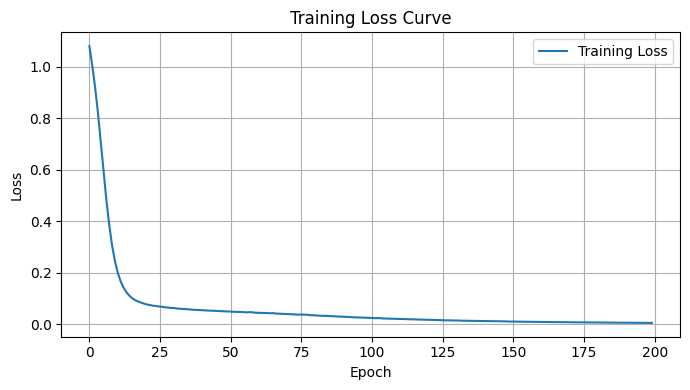

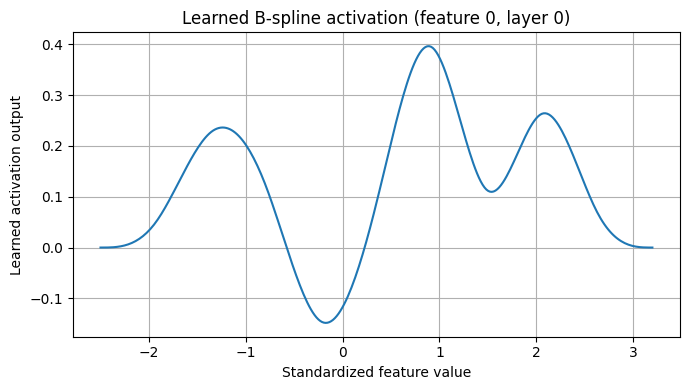

In [9]:

if __name__ == "__main__":
    main()